# Hourly Volume Anomaly Detection 

In [135]:
#!pip install oandapyV20

In [136]:
#!pip install zulu

In [137]:
#!pip install mpl_finance

In [138]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import datetime
import zulu
import os

pd.set_option('display.float_format', '{:.4f}'.format)

In [139]:
ID = '1XX-XXX-XXXXXXX-XX1'
token = '49XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX74'

In [140]:
client = oandapyV20.API(access_token=token)

In [141]:
# To do only to start the dataset
params = {
        "from": "2010-04-01T00:00:00Z",
        "granularity": "H1"}

r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                   params=params)

rv = client.request(r)

dat = []
for oo in r.response['candles']:
    dat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c'], oo['volume']])
    
eurusd = pd.DataFrame(dat)
eurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
eurusd["Time"] = pd.to_datetime(eurusd['Time'])
Date = eurusd['Time']
eurusd['Time'] = eurusd['Time'].apply(mpl_dates.date2num)
eurusd = eurusd.astype(float)
eurusd.head()

,Time,Open,High,Low,Close,Volume
0,733863.0000,1.3527,1.3562,1.3523,1.3530,2442.0000
1,733863.0417,1.3530,1.3530,1.3506,1.3506,1765.0000
2,733863.0833,1.3507,1.3510,1.3496,1.3500,1392.0000
3,733863.1250,1.3500,1.3513,1.3499,1.3507,790.0000
4,733863.1667,1.3507,1.3510,1.3494,1.3504,884.0000


In [142]:
# Loop to feed the dataset with new rates
while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 4:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(hours=1)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "H1"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c'], oo['volume']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)

In [143]:
print(eurusd.shape)
print(Date.iloc[0])
print(Date.iloc[-1])
print(eurusd.head(5))

(63760, 6)
2010-04-01 00:00:00
2020-04-06 06:00:00
         Time   Open   High    Low  Close    Volume
0 733863.0000 1.3527 1.3562 1.3523 1.3530 2442.0000
1 733863.0417 1.3530 1.3530 1.3506 1.3506 1765.0000
2 733863.0833 1.3507 1.3510 1.3496 1.3500 1392.0000
3 733863.1250 1.3500 1.3513 1.3499 1.3507  790.0000
4 733863.1667 1.3507 1.3510 1.3494 1.3504  884.0000


In [144]:
volume = pd.DataFrame(eurusd[["Time", "Volume"]].values, columns=["Time", "Volume"])

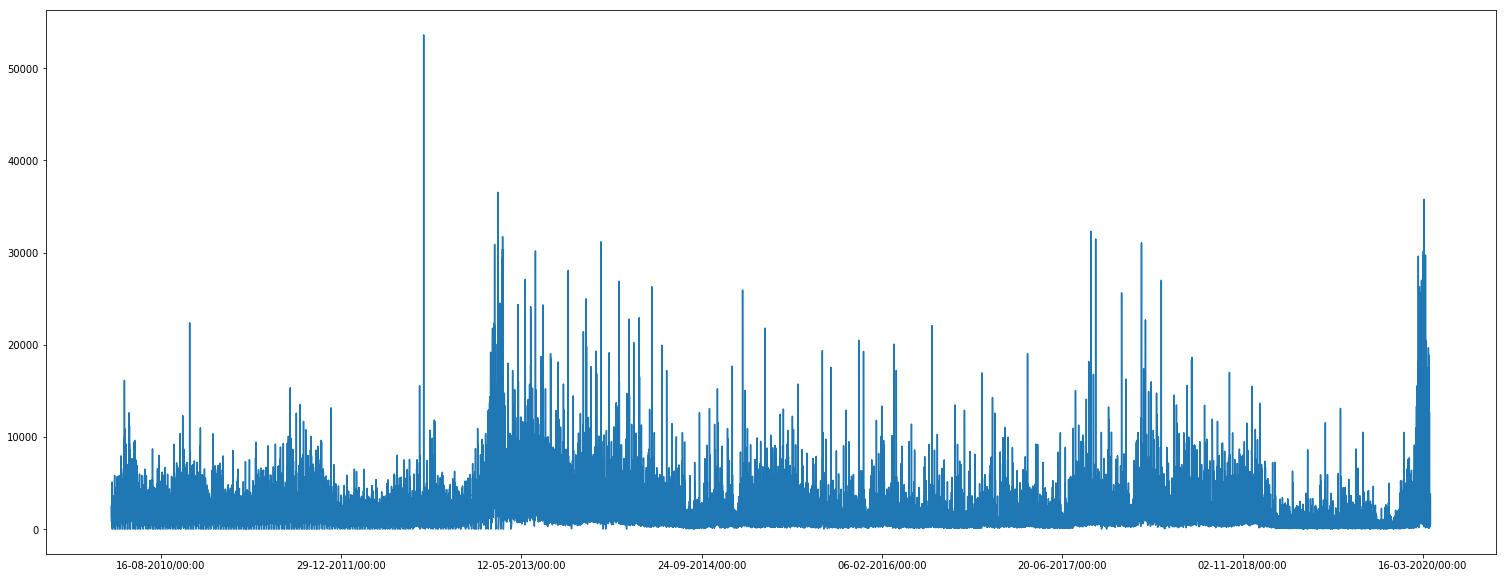

In [145]:
plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k')

ax = plt.gca()
formatter = mpl_dates.DateFormatter("%d-%m-%Y/%H:%M")

ax.xaxis.set_major_formatter(formatter)

plt.plot(volume["Time"], volume["Volume"])

## Isolation Forest for detecting anomalies

In [146]:
# isolation forest multivariate anomaly detector
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples="auto", contamination=float(.005), random_state=0, behaviour="new")
clf.fit(volume["Volume"].values.reshape(-1, 1))
pred = clf.predict(volume["Volume"].values.reshape(-1, 1))

In [147]:
volume['anomaly']=pred
volume = pd.DataFrame(volume)

In [148]:
volume.head(5)

,Time,Volume,anomaly
0,733863.0000,2442.0000,1
1,733863.0417,1765.0000,1
2,733863.0833,1392.0000,1
3,733863.1250,790.0000,1
4,733863.1667,884.0000,1


In [149]:
outliers=volume.loc[volume['anomaly']==-1]

print(volume['anomaly'].value_counts())

 1    63446
-1      314
Name: anomaly, dtype: int64


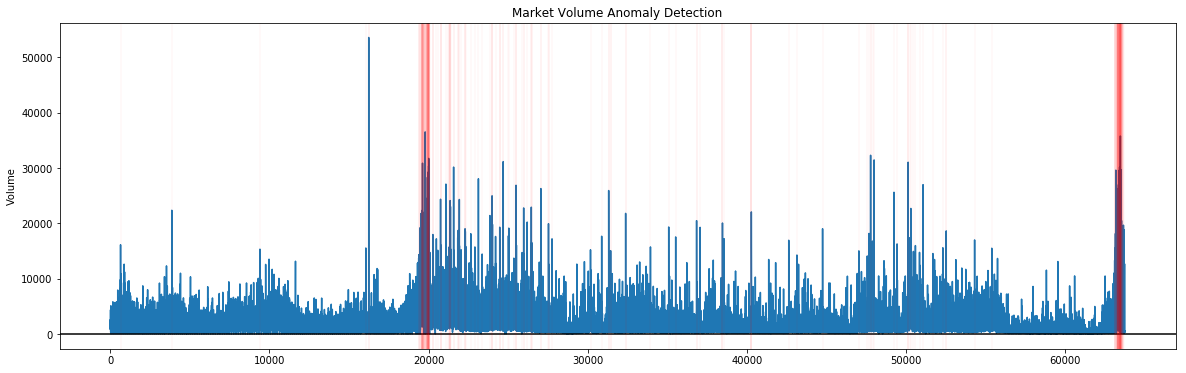

In [152]:
fig, ax = plt.subplots(figsize=(20, 6))

# Labels
ax.set_title('Market Volume Anomaly Detection')
ax.set_ylabel('Volume')

# Plot
ax.plot(volume.index.values, volume["Volume"])
ax.axhline(0, color='black')

for i in range(0, volume.shape[0]):
    score = volume.iloc[i]
    if score[2] < 0:
        l = plt.axvline(x=i, color='red', lw=0.05)

plt.show()